In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# If not already installed
!pip install xgboost

In [11]:
# Import necessary libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical libraries
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Set the style for seaborn
sns.set(style="whitegrid")

# Step 1: Load and Combine Data
# -----------------------------
# Explanation:
# We will traverse through each subfolder, read the 'result.json' file, extract the relevant metrics and hyperparameters, and combine them into a single DataFrame for analysis.

# Specify the path to the main folder containing subfolders of embedding models
main_folder_path = '/content/drive/MyDrive/octis_model_results'

# Initialize an empty list to store data from all models
data_list = []

# Traverse through each subfolder
for embeddings_model in os.listdir(main_folder_path):
    subfolder_path = os.path.join(main_folder_path, embeddings_model)
    result_file_path = os.path.join(subfolder_path, 'result.json')

    # Check if 'result.json' exists in the subfolder
    if os.path.exists(result_file_path):
        # Read the JSON file
        with open(result_file_path, 'r') as file:
            result_data = json.load(file)

        # Extract hyperparameters and metrics
        num_iterations = len(result_data['f_val'])
        for i in range(num_iterations):
            # Skip iterations with failed runs
            if result_data['f_val'][i] == -1 or result_data['dict_model_runs']['0_TopicDiversity'][f'iteration_{i}'][0] == -1:
                continue

            data_point = {
                'Embeddings_Model': embeddings_model,
                'Iteration': i,
                'Coherence': result_data['f_val'][i],
                'Topic_Diversity': result_data['dict_model_runs']['0_TopicDiversity'][f'iteration_{i}'][0],
                # Include hyperparameters
                'bertopic__min_topic_size': result_data['x_iters']['bertopic__min_topic_size'][i],
                'bertopic__top_n_words': result_data['x_iters']['bertopic__top_n_words'][i],
                'hdbscan__min_cluster_size': result_data['x_iters']['hdbscan__min_cluster_size'][i],
                'hdbscan__min_samples': result_data['x_iters']['hdbscan__min_samples'][i],
                'umap__min_dist': result_data['x_iters']['umap__min_dist'][i],
                'umap__n_components': result_data['x_iters']['umap__n_components'][i],
                'umap__n_neighbors': result_data['x_iters']['umap__n_neighbors'][i],
                'vectorizer__min_df': result_data['x_iters']['vectorizer__min_df'][i]
            }
            data_list.append(data_point)

# Create a DataFrame from the data list
df = pd.DataFrame(data_list)

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df.head())

# Data Cleaning (Removing Outliers)
# -----------------------------------------
# Explanation:
# We need to remove outliers from the data before analysis, specifically any runs where the metrics are beyond 2 standard deviations from the mean.
# Additionally, we remove runs where Topic Diversity is exactly 1, as this may indicate a botched run.

# Remove runs where Topic Diversity or Coherence is exactly 1
df = df[df['Topic_Diversity'] < 1.0]
df = df[df['Coherence'] < 1.0]

# Compute the mean and standard deviation for Coherence and Topic Diversity
coherence_mean = df['Coherence'].mean()
coherence_std = df['Coherence'].std()
topic_diversity_mean = df['Topic_Diversity'].mean()
topic_diversity_std = df['Topic_Diversity'].std()

# Define the upper and lower bounds for acceptable values (within 2 standard deviations)
coherence_lower = coherence_mean - 2 * coherence_std
coherence_upper = coherence_mean + 2 * coherence_std
topic_diversity_lower = topic_diversity_mean - 2 * topic_diversity_std
topic_diversity_upper = topic_diversity_mean + 2 * topic_diversity_std

# Remove outliers from Coherence
df = df[(df['Coherence'] >= coherence_lower) & (df['Coherence'] <= coherence_upper)]

# Remove outliers from Topic Diversity
df = df[(df['Topic_Diversity'] >= topic_diversity_lower) & (df['Topic_Diversity'] <= topic_diversity_upper)]

# Reset the index after removing outliers
df = df.reset_index(drop=True)

print("\nData after removing outliers:")
print(df[['Coherence', 'Topic_Diversity']].describe())

# Normalize Coherence and Topic Diversity using Z-score normalization
# -------------------------------------------------------------------
# Initialize the StandardScaler for Z-score normalization
scaler = StandardScaler()

# Apply Z-score normalization to both Coherence and Topic Diversity columns
df[['Coherence_norm', 'Topic_Diversity_norm']] = scaler.fit_transform(df[['Coherence', 'Topic_Diversity']])

# Display the first few rows of the normalized metrics to verify
print("\nFirst few rows of the normalized metrics:")
print(df[['Coherence_norm', 'Topic_Diversity_norm']].head())

# Compute the combined score based on weighted Z-score normalized metrics
# -----------------------------------------------------------------------

# Combined Score with Equal Weights
# ---------------------------------
weight_coherence_equal = 0.5  # Weight for Coherence
weight_topic_diversity_equal = 0.5  # Weight for Topic Diversity

# Compute the combined score with equal weights
df['Combined_Score_Equal_Weights'] = (weight_coherence_equal * df['Coherence_norm']) + (weight_topic_diversity_equal * df['Topic_Diversity_norm'])

# Display the first few rows to check combined score with equal weights
print("\nFirst few rows with combined score (equal weights):")
print(df[['Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score_Equal_Weights']].head())

# Combined Score with Coherence Prioritized
# -----------------------------------------
weight_coherence_prioritized = 0.7  # Higher weight for Coherence
weight_topic_diversity_prioritized = 0.3  # Lower weight for Topic Diversity

# Compute the combined score with coherence prioritized
df['Combined_Score_Coherence_Prioritized'] = (weight_coherence_prioritized * df['Coherence_norm']) + (weight_topic_diversity_prioritized * df['Topic_Diversity_norm'])

# Display the first few rows to check combined score with coherence prioritized
print("\nFirst few rows with combined score (coherence prioritized):")
print(df[['Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score_Coherence_Prioritized']].head())

# Analysis of Hyperparameters' Effects on Metrics
# -----------------------------------------------
# We will analyze how each BERTopic hyperparameter affects:
# a) Coherence
# b) Topic Diversity
# c) Combined Score with Equal Weights
# d) Combined Score with Coherence Prioritized

# Define the list of hyperparameters
hyperparameters = [
    'bertopic__min_topic_size',
    'bertopic__top_n_words',
    'hdbscan__min_cluster_size',
    'hdbscan__min_samples',
    'umap__min_dist',
    'umap__n_components',
    'umap__n_neighbors',
    'vectorizer__min_df'
]

# For clarity, let's create a copy of the DataFrame with relevant columns
data = df.copy()

# Define the metrics to analyze
metrics = [
    'Coherence',
    'Topic_Diversity',
    'Combined_Score_Equal_Weights',
    'Combined_Score_Coherence_Prioritized'
]

# Function to check normality of a variable
def check_normality(variable, alpha=0.05):
    """
    Checks the normality of a variable using the Shapiro-Wilk test.
    Returns True if variable is normally distributed, False otherwise.
    """
    stat, p = stats.shapiro(variable)
    if p > alpha:
        return True  # Fail to reject null hypothesis: data is normally distributed
    else:
        return False  # Reject null hypothesis: data is not normally distributed

# 1. Correlation Analysis with Assumption Checks
# ----------------------------------------------
# For each hyperparameter and metric, we will:
# - Check for normality
# - Choose Pearson correlation if both are normally distributed
# - Else, use Spearman correlation

# Initialize a list to store correlation results
correlation_results_list = []

for metric in metrics:
    for hyperparam in hyperparameters:
        # Check normality for both variables
        normal_hyperparam = check_normality(data[hyperparam])
        normal_metric = check_normality(data[metric])

        # Decide which correlation test to use
        if normal_hyperparam and normal_metric:
            # Both variables are normally distributed; use Pearson correlation
            corr_test = 'Pearson'
            corr_coef, p_value = stats.pearsonr(data[hyperparam], data[metric])
        else:
            # Use Spearman correlation
            corr_test = 'Spearman'
            corr_coef, p_value = stats.spearmanr(data[hyperparam], data[metric])

        # Append the results to the list
        correlation_results_list.append({
            'Hyperparameter': hyperparam,
            'Metric': metric,
            'Test': corr_test,
            'Correlation': corr_coef,
            'P-value': p_value
        })

# Create a DataFrame from the list
correlation_results = pd.DataFrame(correlation_results_list)

# Display the correlation results
print("\nCorrelation Results between Hyperparameters and Metrics:")
print(correlation_results)

# Pivot the results for better visualization
correlation_pivot = correlation_results.pivot(index='Hyperparameter', columns='Metric', values='Correlation')

# Visualize the correlations using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_pivot.astype(float), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Hyperparameters and Metrics')
plt.show()

# 2. Regression Analysis with Assumption Checks
# ---------------------------------------------
# We will perform regression analysis to see the effect of each hyperparameter on each metric.
# Before fitting the model, we will check the necessary assumptions.

for metric in metrics:
    print(f"\nRegression Analysis for {metric}:")

    # Prepare the data
    X = data[hyperparameters]
    y = data[metric]

    # Add a constant term for the intercept
    X_const = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X_const).fit()

    # Check assumptions
    # -----------------
    # 1. Linearity: Assumed due to the nature of the linear model
    # 2. Independence of errors: Assumed since data points are independent runs
    # 3. Homoscedasticity: Use Breusch-Pagan test
    # 4. Normality of residuals: Use Shapiro-Wilk test

    # Extract residuals
    residuals = model.resid
    fitted = model.fittedvalues

    # 3.1 Homoscedasticity Check using Breusch-Pagan test
    from statsmodels.stats.diagnostic import het_breuschpagan
    bp_test = het_breuschpagan(residuals, X_const)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    bp_results = dict(zip(labels, bp_test))

    print("\nBreusch-Pagan test for homoscedasticity:")
    for key in bp_results:
        print(f"{key}: {bp_results[key]}")

    # Interpretation
    if bp_results['LM-Test p-value'] > 0.05:
        print("Fail to reject null hypothesis: Homoscedasticity assumed.")
    else:
        print("Reject null hypothesis: Heteroscedasticity detected.")

    # 3.2 Normality of Residuals using Shapiro-Wilk test
    stat, p = stats.shapiro(residuals)
    print(f"\nShapiro-Wilk test for normality of residuals: Statistic={stat:.3f}, p-value={p:.3f}")

    if p > 0.05:
        print("Fail to reject null hypothesis: Residuals are normally distributed.")
    else:
        print("Reject null hypothesis: Residuals are not normally distributed.")

    # Decide whether to proceed with linear regression or consider transformations
    if bp_results['LM-Test p-value'] > 0.05 and p > 0.05:
        print("\nAssumptions met. Proceeding with linear regression.")
        # Print the summary of the regression model
        print(model.summary())
    else:
        print("\nAssumptions not fully met. Considering robust regression methods or variable transformations.")
        # Optionally, you could perform a transformation or use robust regression
        # For this example, we'll proceed to print the summary but with a note
        print("Note: Interpretation of coefficients may be affected due to assumption violations.")
        print(model.summary())

    # Optionally, you can plot residuals vs fitted values to check for patterns
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=fitted, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Fitted Values for {metric}')
    plt.show()

# 3. Multicollinearity Check
# --------------------------
# We will check for multicollinearity among hyperparameters using Variance Inflation Factor (VIF).

# Prepare the data
X = data[hyperparameters]

# Calculate VIF for each hyperparameter
vif_data = pd.DataFrame()
vif_data['Hyperparameter'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("\nVariance Inflation Factor (VIF) for Hyperparameters:")
print(vif_data)

# Interpretation
# VIF > 5 indicates multicollinearity.
high_vif = vif_data[vif_data['VIF'] > 5]
if not high_vif.empty:
    print("\nHyperparameters with high VIF indicating multicollinearity:")
    print(high_vif)
else:
    print("\nNo multicollinearity detected among hyperparameters.")

# 4. Visualization of Relationships
# ----------------------------------
# We will create scatter plots to visualize the relationship between each hyperparameter and each metric.
# We can also include regression lines if appropriate.

for metric in metrics:
    for hyperparam in hyperparameters:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=data, x=hyperparam, y=metric, alpha=0.5)
        plt.title(f'{metric} vs. {hyperparam}')
        plt.xlabel(hyperparam)
        plt.ylabel(metric)
        plt.show()

# 5. Feature Importance using Random Forest
# -----------------------------------------
# If linear regression assumptions are violated, tree-based models can be useful as they do not require the same assumptions.

from sklearn.ensemble import RandomForestRegressor

for metric in metrics:
    print(f"\nRandom Forest Feature Importances for {metric}:")

    # Prepare the data
    X = data[hyperparameters]
    y = data[metric]

    # Initialize the Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    # Fit the model
    rf.fit(X, y)

    # Get feature importances
    importances = rf.feature_importances_

    # Create a DataFrame for feature importances
    feature_importances = pd.DataFrame({
        'Feature': hyperparameters,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Display the feature importances
    print(feature_importances)

    # Visualize the feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances)
    plt.title(f'Feature Importances for {metric}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# 6. Summary of Significant Hyperparameters
# -----------------------------------------
# Based on the regression analysis and correlation results, we can summarize which hyperparameters have a significant effect on each metric.

# Define a significance level
alpha = 0.05

for metric in metrics:
    print(f"\nSignificant Hyperparameters for {metric} (p-value < {alpha}):")

    # Prepare the data
    X = data[hyperparameters]
    y = data[metric]

    # Add a constant term
    X_const = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X_const).fit()

    # Get p-values
    pvalues = model.pvalues

    # Get significant hyperparameters
    significant_params = pvalues[pvalues < alpha].index

    # Exclude the constant term
    significant_hyperparams = [param for param in significant_params if param != 'const']

    # Display the significant hyperparameters
    if significant_hyperparams:
        print(significant_hyperparams)
    else:
        print("No hyperparameters are statistically significant at the specified alpha level.")

# Conclusion
# ----------
# The code above performs the analysis to assess how each BERTopic hyperparameter affects:
# a) Coherence
# b) Topic Diversity
# c) Combined Score with Equal Weights
# d) Combined Score with Coherence Prioritized

# Each step includes checks for statistical assumptions and chooses the appropriate tests based on those checks.

# Variables are defined comprehensively, and explanations are provided for each step.

Output hidden; open in https://colab.research.google.com to view.

First few rows of the DataFrame:
           Embeddings_Model  Iteration  Coherence  Topic_Diversity  \
0  paraphrase-mpnet-base-v2          0   0.463245         0.820000   
1  paraphrase-mpnet-base-v2          1   0.294120         0.975000   
2  paraphrase-mpnet-base-v2          2   0.428778         0.673810   
3  paraphrase-mpnet-base-v2          3   0.289018         0.842857   
4  paraphrase-mpnet-base-v2          4   0.345422         0.900000   

   bertopic__min_topic_size  bertopic__top_n_words  hdbscan__min_cluster_size  \
0                       127                     31                        494   
1                        57                     37                        132   
2                       143                     35                        432   
3                       234                     25                        100   
4                       182                     18                        493   

   hdbscan__min_samples  umap__min_dist  umap__n_components

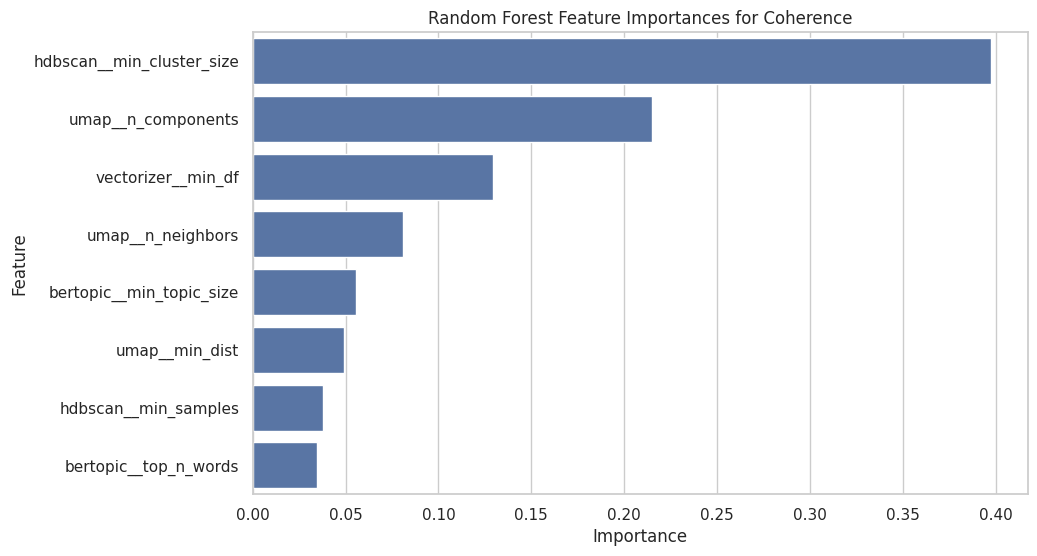


XGBoost Regression Analysis for Coherence:
Cross-validated R² scores: [0.43604516 0.28324601 0.51483135 0.30662725 0.5647349 ]
Mean R² score: 0.42109693401522996

Feature Importances:
                     Feature  Importance
5         umap__n_components    0.378388
2  hdbscan__min_cluster_size    0.312482
7         vectorizer__min_df    0.095438
6          umap__n_neighbors    0.075794
4             umap__min_dist    0.045178
3       hdbscan__min_samples    0.037690
0   bertopic__min_topic_size    0.031750
1      bertopic__top_n_words    0.023280


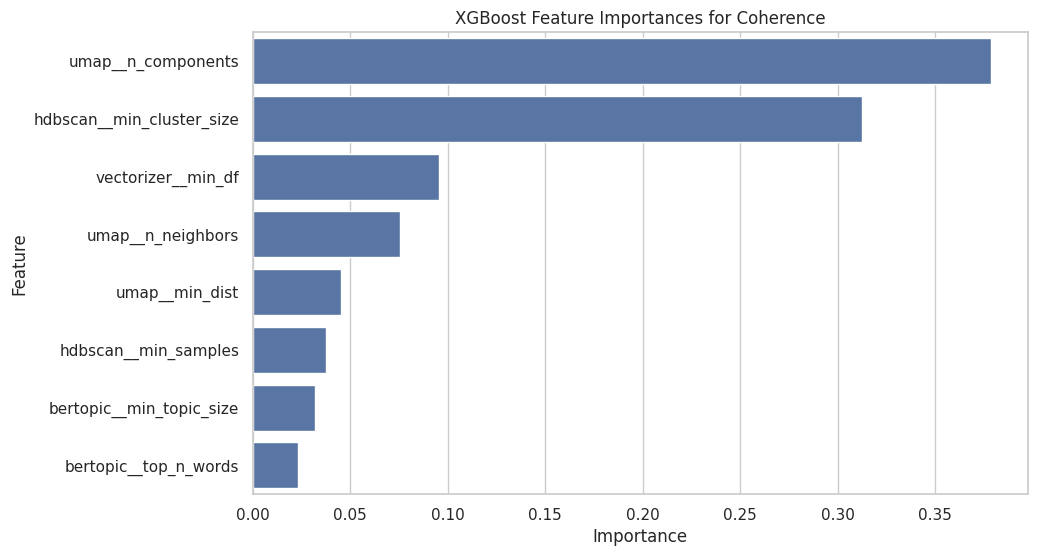


===== Analysis for Topic_Diversity =====

Random Forest Regression Analysis for Topic_Diversity:
Cross-validated R² scores: [0.33924139 0.20187562 0.33890874 0.18028436 0.53982397]
Mean R² score: 0.32002681333050215

Feature Importances:
                     Feature  Importance
6          umap__n_neighbors    0.262831
4             umap__min_dist    0.185663
2  hdbscan__min_cluster_size    0.129175
7         vectorizer__min_df    0.119297
5         umap__n_components    0.109372
3       hdbscan__min_samples    0.079236
0   bertopic__min_topic_size    0.061138
1      bertopic__top_n_words    0.053290


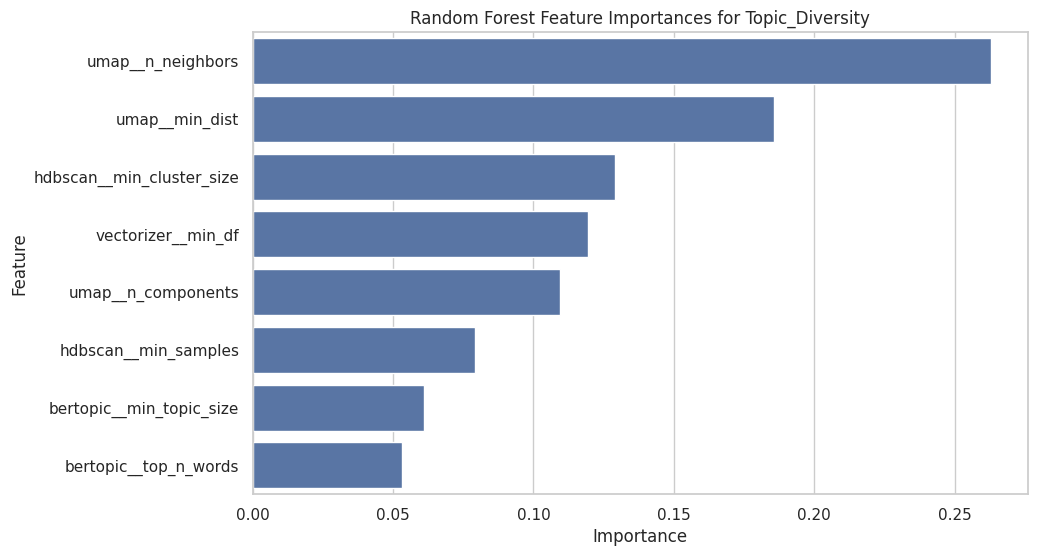


XGBoost Regression Analysis for Topic_Diversity:
Cross-validated R² scores: [0.24909003 0.21784828 0.30836943 0.13224561 0.51560898]
Mean R² score: 0.28463246727034397

Feature Importances:
                     Feature  Importance
6          umap__n_neighbors    0.329854
4             umap__min_dist    0.179460
5         umap__n_components    0.160926
2  hdbscan__min_cluster_size    0.089733
7         vectorizer__min_df    0.082605
3       hdbscan__min_samples    0.074484
1      bertopic__top_n_words    0.047343
0   bertopic__min_topic_size    0.035595


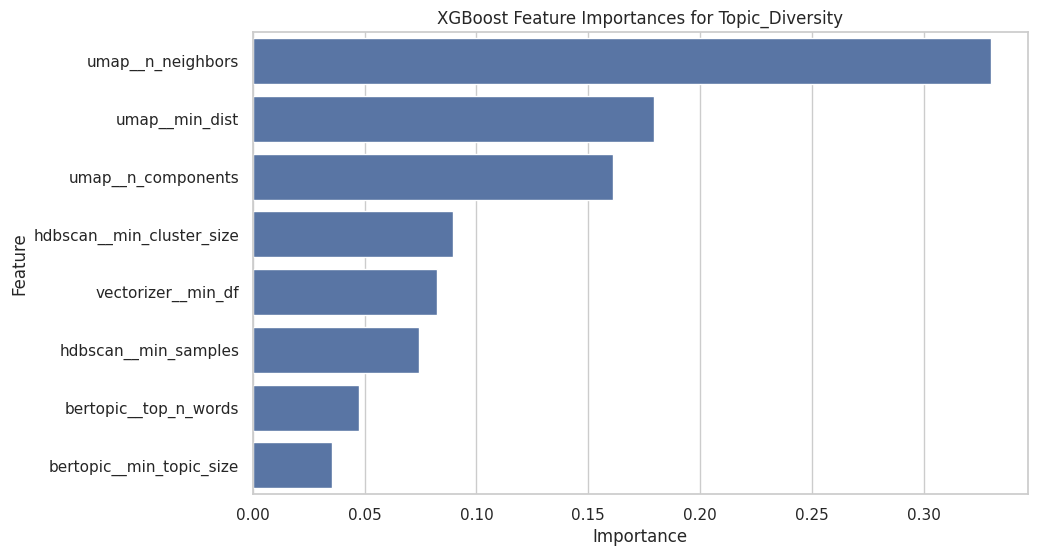


===== Analysis for Combined_Score_Equal_Weights =====

Random Forest Regression Analysis for Combined_Score_Equal_Weights:
Cross-validated R² scores: [0.42974645 0.29701992 0.55679906 0.34977563 0.51267052]
Mean R² score: 0.4292023155674253

Feature Importances:
                     Feature  Importance
2  hdbscan__min_cluster_size    0.364123
6          umap__n_neighbors    0.207002
4             umap__min_dist    0.107245
7         vectorizer__min_df    0.086708
5         umap__n_components    0.062415
3       hdbscan__min_samples    0.059573
1      bertopic__top_n_words    0.058315
0   bertopic__min_topic_size    0.054620


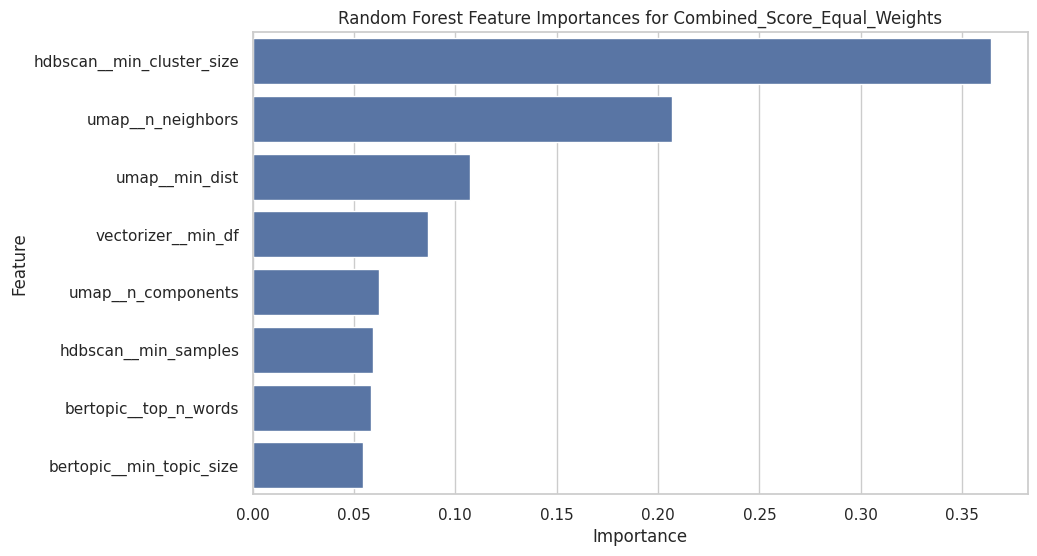


XGBoost Regression Analysis for Combined_Score_Equal_Weights:
Cross-validated R² scores: [0.44660787 0.24815023 0.57252638 0.26544987 0.31677993]
Mean R² score: 0.3699028559486769

Feature Importances:
                     Feature  Importance
6          umap__n_neighbors    0.356115
2  hdbscan__min_cluster_size    0.265804
5         umap__n_components    0.139812
4             umap__min_dist    0.070198
7         vectorizer__min_df    0.059222
1      bertopic__top_n_words    0.044822
3       hdbscan__min_samples    0.038118
0   bertopic__min_topic_size    0.025907


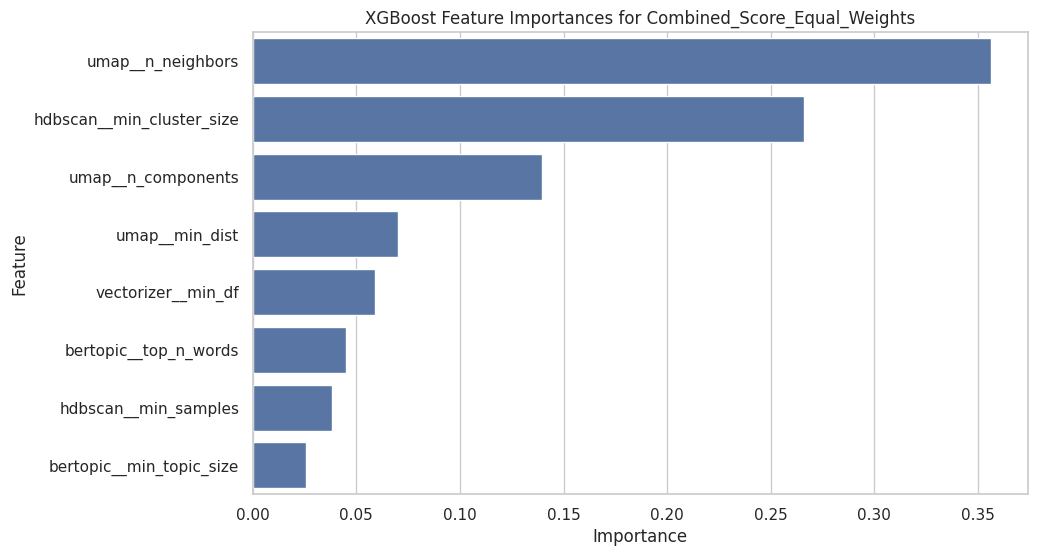


===== Analysis for Combined_Score_Coherence_Prioritized =====

Random Forest Regression Analysis for Combined_Score_Coherence_Prioritized:
Cross-validated R² scores: [0.36425863 0.25304958 0.65256686 0.48925175 0.6063432 ]
Mean R² score: 0.4730940045695407

Feature Importances:
                     Feature  Importance
2  hdbscan__min_cluster_size    0.447268
5         umap__n_components    0.168469
6          umap__n_neighbors    0.097267
7         vectorizer__min_df    0.084868
4             umap__min_dist    0.064459
0   bertopic__min_topic_size    0.062727
3       hdbscan__min_samples    0.040822
1      bertopic__top_n_words    0.034121


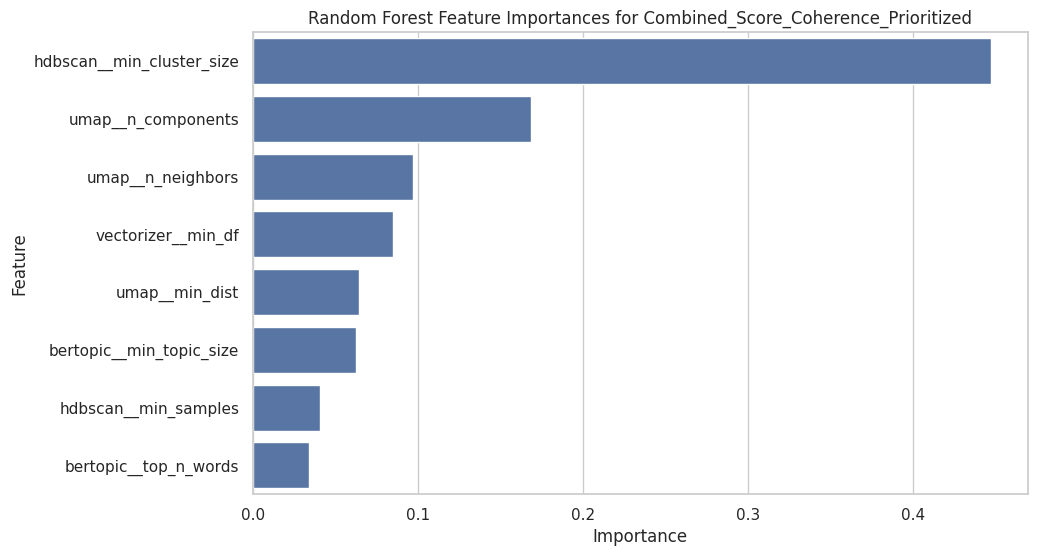


XGBoost Regression Analysis for Combined_Score_Coherence_Prioritized:
Cross-validated R² scores: [0.2792195  0.30926182 0.66319605 0.41322385 0.45638961]
Mean R² score: 0.4242581680944859

Feature Importances:
                     Feature  Importance
5         umap__n_components    0.385133
2  hdbscan__min_cluster_size    0.272151
6          umap__n_neighbors    0.139995
7         vectorizer__min_df    0.070368
4             umap__min_dist    0.042302
3       hdbscan__min_samples    0.039200
0   bertopic__min_topic_size    0.036803
1      bertopic__top_n_words    0.014048


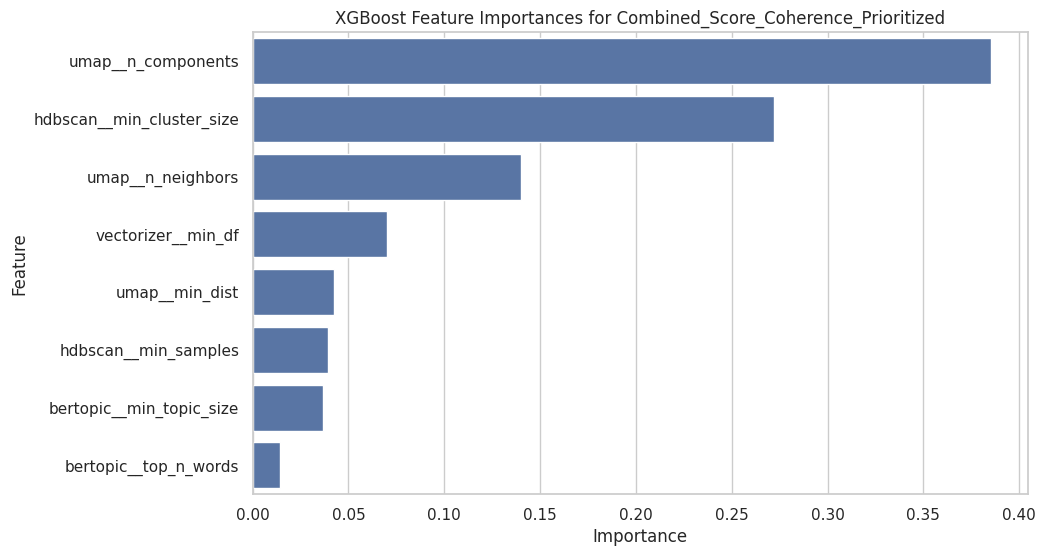

In [15]:
# Full Code for Applying Random Forest Regression and XGBoost Regression

# Import necessary libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical libraries
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor

# For XGBoost
try:
    from xgboost import XGBRegressor
except ImportError:
    # Install XGBoost if not already installed
    !pip install xgboost
    from xgboost import XGBRegressor

# Set the style for seaborn
sns.set(style="whitegrid")

# Step 1: Load and Combine Data
# -----------------------------
# Explanation:
# We will traverse through each subfolder, read the 'result.json' file, extract the relevant metrics and hyperparameters, and combine them into a single DataFrame for analysis.

# Specify the path to the main folder containing subfolders of embedding models
main_folder_path = '/content/drive/MyDrive/octis_model_results'

# Initialize an empty list to store data from all models
data_list = []

# Traverse through each subfolder
for embeddings_model in os.listdir(main_folder_path):
    subfolder_path = os.path.join(main_folder_path, embeddings_model)
    result_file_path = os.path.join(subfolder_path, 'result.json')

    # Check if 'result.json' exists in the subfolder
    if os.path.exists(result_file_path):
        # Read the JSON file
        with open(result_file_path, 'r') as file:
            result_data = json.load(file)

        # Extract hyperparameters and metrics
        num_iterations = len(result_data['f_val'])
        for i in range(num_iterations):
            # Skip iterations with failed runs
            if result_data['f_val'][i] == -1 or result_data['dict_model_runs']['0_TopicDiversity'][f'iteration_{i}'][0] == -1:
                continue

            data_point = {
                'Embeddings_Model': embeddings_model,
                'Iteration': i,
                'Coherence': result_data['f_val'][i],
                'Topic_Diversity': result_data['dict_model_runs']['0_TopicDiversity'][f'iteration_{i}'][0],
                # Include hyperparameters
                'bertopic__min_topic_size': result_data['x_iters']['bertopic__min_topic_size'][i],
                'bertopic__top_n_words': result_data['x_iters']['bertopic__top_n_words'][i],
                'hdbscan__min_cluster_size': result_data['x_iters']['hdbscan__min_cluster_size'][i],
                'hdbscan__min_samples': result_data['x_iters']['hdbscan__min_samples'][i],
                'umap__min_dist': result_data['x_iters']['umap__min_dist'][i],
                'umap__n_components': result_data['x_iters']['umap__n_components'][i],
                'umap__n_neighbors': result_data['x_iters']['umap__n_neighbors'][i],
                'vectorizer__min_df': result_data['x_iters']['vectorizer__min_df'][i]
            }
            data_list.append(data_point)

# Create a DataFrame from the data list
df = pd.DataFrame(data_list)

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df.head())

# Data Cleaning (Removing Outliers)
# -----------------------------------------
# Remove runs where Topic Diversity or Coherence is exactly 1
df = df[df['Topic_Diversity'] < 1.0]
df = df[df['Coherence'] < 1.0]

# Compute the mean and standard deviation for Coherence and Topic Diversity
coherence_mean = df['Coherence'].mean()
coherence_std = df['Coherence'].std()
topic_diversity_mean = df['Topic_Diversity'].mean()
topic_diversity_std = df['Topic_Diversity'].std()

# Define the upper and lower bounds for acceptable values (within 2 standard deviations)
coherence_lower = coherence_mean - 2 * coherence_std
coherence_upper = coherence_mean + 2 * coherence_std
topic_diversity_lower = topic_diversity_mean - 2 * topic_diversity_std
topic_diversity_upper = topic_diversity_mean + 2 * topic_diversity_std

# Remove outliers from Coherence
df = df[(df['Coherence'] >= coherence_lower) & (df['Coherence'] <= coherence_upper)]

# Remove outliers from Topic Diversity
df = df[(df['Topic_Diversity'] >= topic_diversity_lower) & (df['Topic_Diversity'] <= topic_diversity_upper)]

# Reset the index after removing outliers
df = df.reset_index(drop=True)

print("\nData after removing outliers:")
print(df[['Coherence', 'Topic_Diversity']].describe())

# Normalize Coherence and Topic Diversity using Z-score normalization
# -------------------------------------------------------------------
# Initialize the StandardScaler for Z-score normalization
scaler = StandardScaler()

# Apply Z-score normalization to both Coherence and Topic Diversity columns
df[['Coherence_norm', 'Topic_Diversity_norm']] = scaler.fit_transform(df[['Coherence', 'Topic_Diversity']])

# Display the first few rows of the normalized metrics to verify
print("\nFirst few rows of the normalized metrics:")
print(df[['Coherence_norm', 'Topic_Diversity_norm']].head())

# Compute the combined score based on weighted Z-score normalized metrics
# -----------------------------------------------------------------------

# Combined Score with Equal Weights
# ---------------------------------
weight_coherence_equal = 0.5  # Weight for Coherence
weight_topic_diversity_equal = 0.5  # Weight for Topic Diversity

# Compute the combined score with equal weights
df['Combined_Score_Equal_Weights'] = (weight_coherence_equal * df['Coherence_norm']) + (weight_topic_diversity_equal * df['Topic_Diversity_norm'])

# Display the first few rows to check combined score with equal weights
print("\nFirst few rows with combined score (equal weights):")
print(df[['Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score_Equal_Weights']].head())

# Combined Score with Coherence Prioritized
# -----------------------------------------
weight_coherence_prioritized = 0.7  # Higher weight for Coherence
weight_topic_diversity_prioritized = 0.3  # Lower weight for Topic Diversity

# Compute the combined score with coherence prioritized
df['Combined_Score_Coherence_Prioritized'] = (weight_coherence_prioritized * df['Coherence_norm']) + (weight_topic_diversity_prioritized * df['Topic_Diversity_norm'])

# Display the first few rows to check combined score with coherence prioritized
print("\nFirst few rows with combined score (coherence prioritized):")
print(df[['Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score_Coherence_Prioritized']].head())

# Analysis of Hyperparameters' Effects on Metrics using Random Forest and XGBoost
# ------------------------------------------------------------------------------

# Define the list of hyperparameters
hyperparameters = [
    'bertopic__min_topic_size',
    'bertopic__top_n_words',
    'hdbscan__min_cluster_size',
    'hdbscan__min_samples',
    'umap__min_dist',
    'umap__n_components',
    'umap__n_neighbors',
    'vectorizer__min_df'
]

# Define the metrics to analyze
metrics = [
    'Coherence',
    'Topic_Diversity',
    'Combined_Score_Equal_Weights',
    'Combined_Score_Coherence_Prioritized'
]

# Function to perform Random Forest Regression
def random_forest_analysis(X, y, metric_name):
    print(f"\nRandom Forest Regression Analysis for {metric_name}:")

    # Initialize the Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='r2')
    print("Cross-validated R² scores:", cv_scores)
    print("Mean R² score:", cv_scores.mean())

    # Fit the model on the entire dataset
    rf_model.fit(X, y)

    # Feature Importances
    importances = rf_model.feature_importances_
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Display the feature importances
    print("\nFeature Importances:")
    print(feature_importances)

    # Visualize the feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances)
    plt.title(f'Random Forest Feature Importances for {metric_name}')
    plt.show()

# Function to perform XGBoost Regression
def xgboost_analysis(X, y, metric_name):
    print(f"\nXGBoost Regression Analysis for {metric_name}:")

    # Initialize the XGBoost Regressor
    xgb_model = XGBRegressor(n_estimators=100, random_state=42)

    # Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='r2')
    print("Cross-validated R² scores:", cv_scores)
    print("Mean R² score:", cv_scores.mean())

    # Fit the model on the entire dataset
    xgb_model.fit(X, y)

    # Feature Importances
    importances = xgb_model.feature_importances_
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Display the feature importances
    print("\nFeature Importances:")
    print(feature_importances)

    # Visualize the feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances)
    plt.title(f'XGBoost Feature Importances for {metric_name}')
    plt.show()

# Perform analysis for each metric
for metric in metrics:
    print(f"\n===== Analysis for {metric} =====")
    X = df[hyperparameters]
    y = df[metric]

    # Random Forest Analysis
    random_forest_analysis(X, y, metric)

    # XGBoost Analysis
    xgboost_analysis(X, y, metric)


In [12]:
# Assuming 'df' is our cleaned DataFrame from previous steps
# The hyperparameters and metrics are defined as:

hyperparameters = [
    'bertopic__min_topic_size',
    'bertopic__top_n_words',
    'hdbscan__min_cluster_size',
    'hdbscan__min_samples',
    'umap__min_dist',
    'umap__n_components',
    'umap__n_neighbors',
    'vectorizer__min_df'
]

metrics = [
    'Coherence',
    'Topic_Diversity',
    'Combined_Score_Equal_Weights',
    'Combined_Score_Coherence_Prioritized'
]